In [1]:
# yfinance, getFamaFrenchFactors 패키지 설치
# !pip install yfinance --quiet
# !pip install getFamaFrenchFactors -- quiet

In [1]:
# 패키지 임포트
import pandas as pd
import yfinance as yf
import statsmodels.api as sm 
import getFamaFrenchFactors as gff

### 애플 과거 추가 데이터 다운로드

In [4]:
# 주가 데이터 다운로드
# 애플 주가 티커
ticker = 'AAPL'

# 데이터 시작일과 종료일
start = '2000-01-01'
end = '2022-10-12'

# 데이터 다운로드
stock_data = yf.download(ticker, start, end)

# 주가 수익률 계산
stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = 'Month_Rtn'
stock_returns.index = pd.to_datetime(stock_returns.index).date

stock_returns

[*********************100%***********************]  1 of 1 completed


2000-02-29    0.104820
2000-03-31    0.184841
2000-04-30   -0.086516
2000-05-31   -0.322922
2000-06-30    0.247024
                ...   
2022-06-30   -0.081430
2022-07-31    0.188634
2022-08-31   -0.031208
2022-09-30   -0.120977
2022-10-31    0.005644
Name: Month_Rtn, Length: 273, dtype: float64

### 파마-프렌트 3 팩터 데이터 다운로드

In [6]:
# 파마-프렌치 3 팩터 데이터 다운로드
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={'date_ff_factors': 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly.index = pd.to_datetime(ff3_monthly.index).date

# 팩터 데이터와 주가 데이터 병합
ff_data = pd.concat([ff3_monthly, stock_returns], axis=1, join='inner')

ff_data

,Mkt-RF,SMB,HML,RF,Month_Rtn
2000-02-29,0.0245,0.2142,-0.0970,0.0043,0.104820
2000-03-31,0.0520,-0.1723,0.0817,0.0047,0.184841
2000-04-30,-0.0640,-0.0668,0.0726,0.0046,-0.086516
2000-05-31,-0.0442,-0.0609,0.0481,0.0050,-0.322922
2000-06-30,0.0464,0.1285,-0.0843,0.0040,0.247024
...,...,...,...,...,...
2022-06-30,-0.0843,0.0209,-0.0597,0.0006,-0.081430
2022-07-31,0.0957,0.0281,-0.0410,0.0008,0.188634
2022-08-31,-0.0377,0.0139,0.0031,0.0019,-0.031208
2022-09-30,-0.0935,-0.0082,0.0003,0.0019,-0.120977


In [7]:
# ff_data 데이터플레임 칼럼 이름 변경
ff_data.columns = ['beta', 'size', 'value', 'rf', 'ret']

# 결과
ff_data

,beta,size,value,rf,ret
2000-02-29,0.0245,0.2142,-0.0970,0.0043,0.104820
2000-03-31,0.0520,-0.1723,0.0817,0.0047,0.184841
2000-04-30,-0.0640,-0.0668,0.0726,0.0046,-0.086516
2000-05-31,-0.0442,-0.0609,0.0481,0.0050,-0.322922
2000-06-30,0.0464,0.1285,-0.0843,0.0040,0.247024
...,...,...,...,...,...
2022-06-30,-0.0843,0.0209,-0.0597,0.0006,-0.081430
2022-07-31,0.0957,0.0281,-0.0410,0.0008,0.188634
2022-08-31,-0.0377,0.0139,0.0031,0.0019,-0.031208
2022-09-30,-0.0935,-0.0082,0.0003,0.0019,-0.120977


### 파마-프렌치 3 팩터 모델로 주간 선형 회귀분석

In [8]:
# 회귀분석 설명변수 : 베타, 사이즈, 벨류
X = ff_data[['beta', 'size', 'value']]

# 회귀분석 종속변수: 애플 주식의 무위험 초과 수익률
y = ff_data['ret'] - ff_data['rf']

# 데이터를 회귀분석 모델에 학습시키기
ff_model = sm.OLS(y, X).fit()

# 회귀분석 결과 출력
print(ff_model.summary())

# 베타 계수 할당
b1, b2, b3 = ff_model.params

b1, b2, b3

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.369
Model:                            OLS   Adj. R-squared (uncentered):              0.362
Method:                 Least Squares   F-statistic:                              52.56
Date:                Mon, 20 Feb 2023   Prob (F-statistic):                    8.70e-27
Time:                        23:43:55   Log-Likelihood:                          262.37
No. Observations:                 273   AIC:                                     -518.7
Df Residuals:                     270   BIC:                                     -507.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

(1.371130732449775, 0.10537077042835133, -0.7714827308666317)

In [9]:
# 무위험수익률
rf = ff_data['rf'].mean()

# 시장 위험 프리미엄
market_premium = ff_data['beta'].mean()

# 사이즈 프리미엄
size_premium = ff_data['size'].mean()

# 밸류 프리미엄
value_premium = ff_data['value'].mean()

# 팩터를 활용한 기대수익률 계산
# 월간 기대수익률
expected_monthly_return = rf + b1 * market_premium + b2 * size_premium + b3 * value_premium

# 연간 기대수익률
expected_yearly_return = expected_monthly_return * 12

# 기대수익률 출력
print('Expected Yearly Return : ' + str(expected_yearly_return))

Expected Yearly Return : 0.08102277215155393


### 시간 가변적 베타 (time-varying beta)

In [10]:
# rolling OLS 임포트
from statsmodels.regression.rolling import RollingOLS

In [13]:
# 3-팩터 롤링 베타 추출
betas = RollingOLS.from_formula('ret ~ beta + size + value', data=ff_data, window=36).fit().params
betas

,Intercept,beta,size,value
2000-02-29,NaN,NaN,NaN,NaN
2000-03-31,NaN,NaN,NaN,NaN
2000-04-30,NaN,NaN,NaN,NaN
2000-05-31,NaN,NaN,NaN,NaN
2000-06-30,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-06-30,0.022748,1.292452,-0.598421,-0.453837
2022-07-31,0.022798,1.314895,-0.558704,-0.472186
2022-08-31,0.024304,1.304921,-0.587340,-0.493836
2022-09-30,0.021797,1.320926,-0.566634,-0.534356


<Axes: >

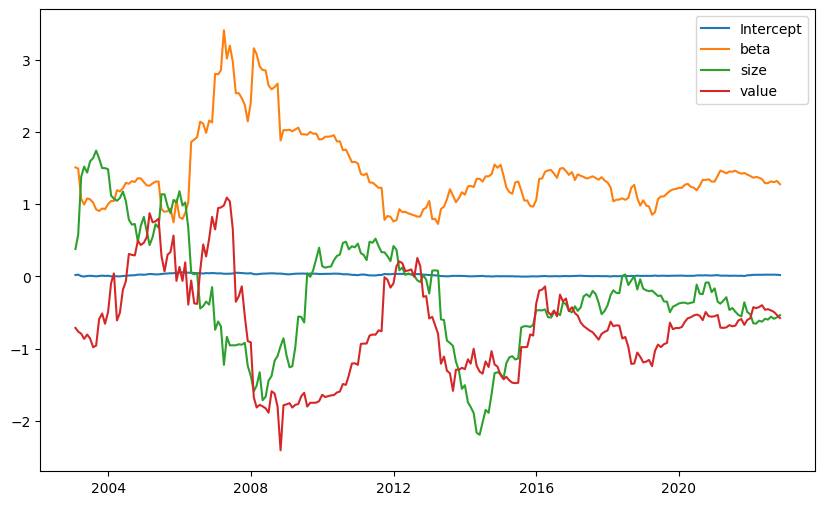

In [14]:
# 팩터 계수 그래프
betas.dropna().plot(figsize=(10, 6))